In [60]:
 !pip install -i https://pypi.tuna.tsinghua.edu.cn/simple tensorflow numpy pandas matplotlib scikit-learn pydot graphviz

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [10]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras

print(tf.__version__)
print('GPU is', tf.config.list_physical_devices())

2.16.1
GPU is [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
all_data = pd.read_csv('dataset/train.csv', names=['sentiment', 'text'])
all_data = all_data.sample(130000, random_state=0)
# replace sentiment with 0 and 1
all_data['sentiment'] = all_data['sentiment'].replace(1, 0) # Negative
all_data['sentiment'] = all_data['sentiment'].replace(2, 1) # Positive
train = all_data.sample(frac=0.6, random_state=0)
val = all_data.drop(train.index)
test = val.sample(frac=0.5, random_state=0)
val = val.drop(test.index)
print(train.head())

batch_size = 64
test_ds = tf.data.Dataset.from_tensor_slices((test['text'].values, test['sentiment'].values)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val['text'].values, val['sentiment'].values)).batch(batch_size)
train_ds = tf.data.Dataset.from_tensor_slices((train['text'].values, train['sentiment'].values)).batch(batch_size)

        sentiment                                               text
400911          0  Visiting here to purchase goodies for a GF fri...
401060          1  What's up Doc? A rabbit burger on the brunch m...
509186          1  What can you say its a movie theater. Popcorn ...
440605          0  This place sucks! They forgot to put egg in my...
450298          0  After a long walk on the strip, i was hungry a...


In [12]:
from tensorflow.keras import layers, losses
import re
import string

max_features = 2000
sequence_length = 500

def custom_standardization(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, 'https?://[\w./?&=#-]+', '')
    text = tf.strings.regex_replace(text, r'@\w+', '')
    text = tf.strings.regex_replace(text, r'\\n', ' ')
    text = tf.strings.regex_replace(text, r' +', ' ')
    return tf.strings.regex_replace(text, '[%s]' % re.escape(string.punctuation), '')

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(train['text'].values)

In [13]:
# retrieve a batch

print(vectorize_layer.get_vocabulary()[:5])
print(vectorize_layer(train_ds.take(1).as_numpy_iterator().next()[0]))

['', '[UNK]', 'the', 'and', 'i']
tf.Tensor(
[[1090   45    5 ...    0    0    0]
 [1096   52    1 ...    0    0    0]
 [  61   77   20 ...    0    0    0]
 ...
 [  15   23   68 ...    0    0    0]
 [   1   71 1475 ...    0    0    0]
 [   1    8  293 ...    0    0    0]], shape=(64, 500), dtype=int64)


In [14]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [15]:
embedding_dim = 16

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, sequence_length, max_features, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.embedding = layers.Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)
        self.position_embedding = layers.Embedding(input_dim=sequence_length, output_dim=embedding_dim)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.embedding(inputs)
        embedded_positions = self.position_embedding(positions)
        return embedded_tokens + embedded_positions

class TransformerBlock(layers.Layer):
    def __init__(self, embedding_dim, num_heads=2, ff_dim=32, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embedding_dim),
        ])
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=True):
        attention_output = self.attention(inputs, inputs)
        attention_output = self.dropout1(attention_output, training=training)
        out1 = self.layer_norm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layer_norm2(out1 + ffn_output)

model = keras.Sequential([
    TokenAndPositionEmbedding(sequence_length, max_features, embedding_dim),
    TransformerBlock(embedding_dim, num_heads=2, ff_dim=32),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1),
])

model.build(input_shape=(None, sequence_length))

model.summary(expand_nested=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ token_and_position_embedding_1  │ (None, 500, 16)        │        40,000 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 500, 16)        │         3,296 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,313 (169.19 KB)

 Trainable params: 43,313 (169.19 KB)

 Non-trainable params: 0 (0.00 B)

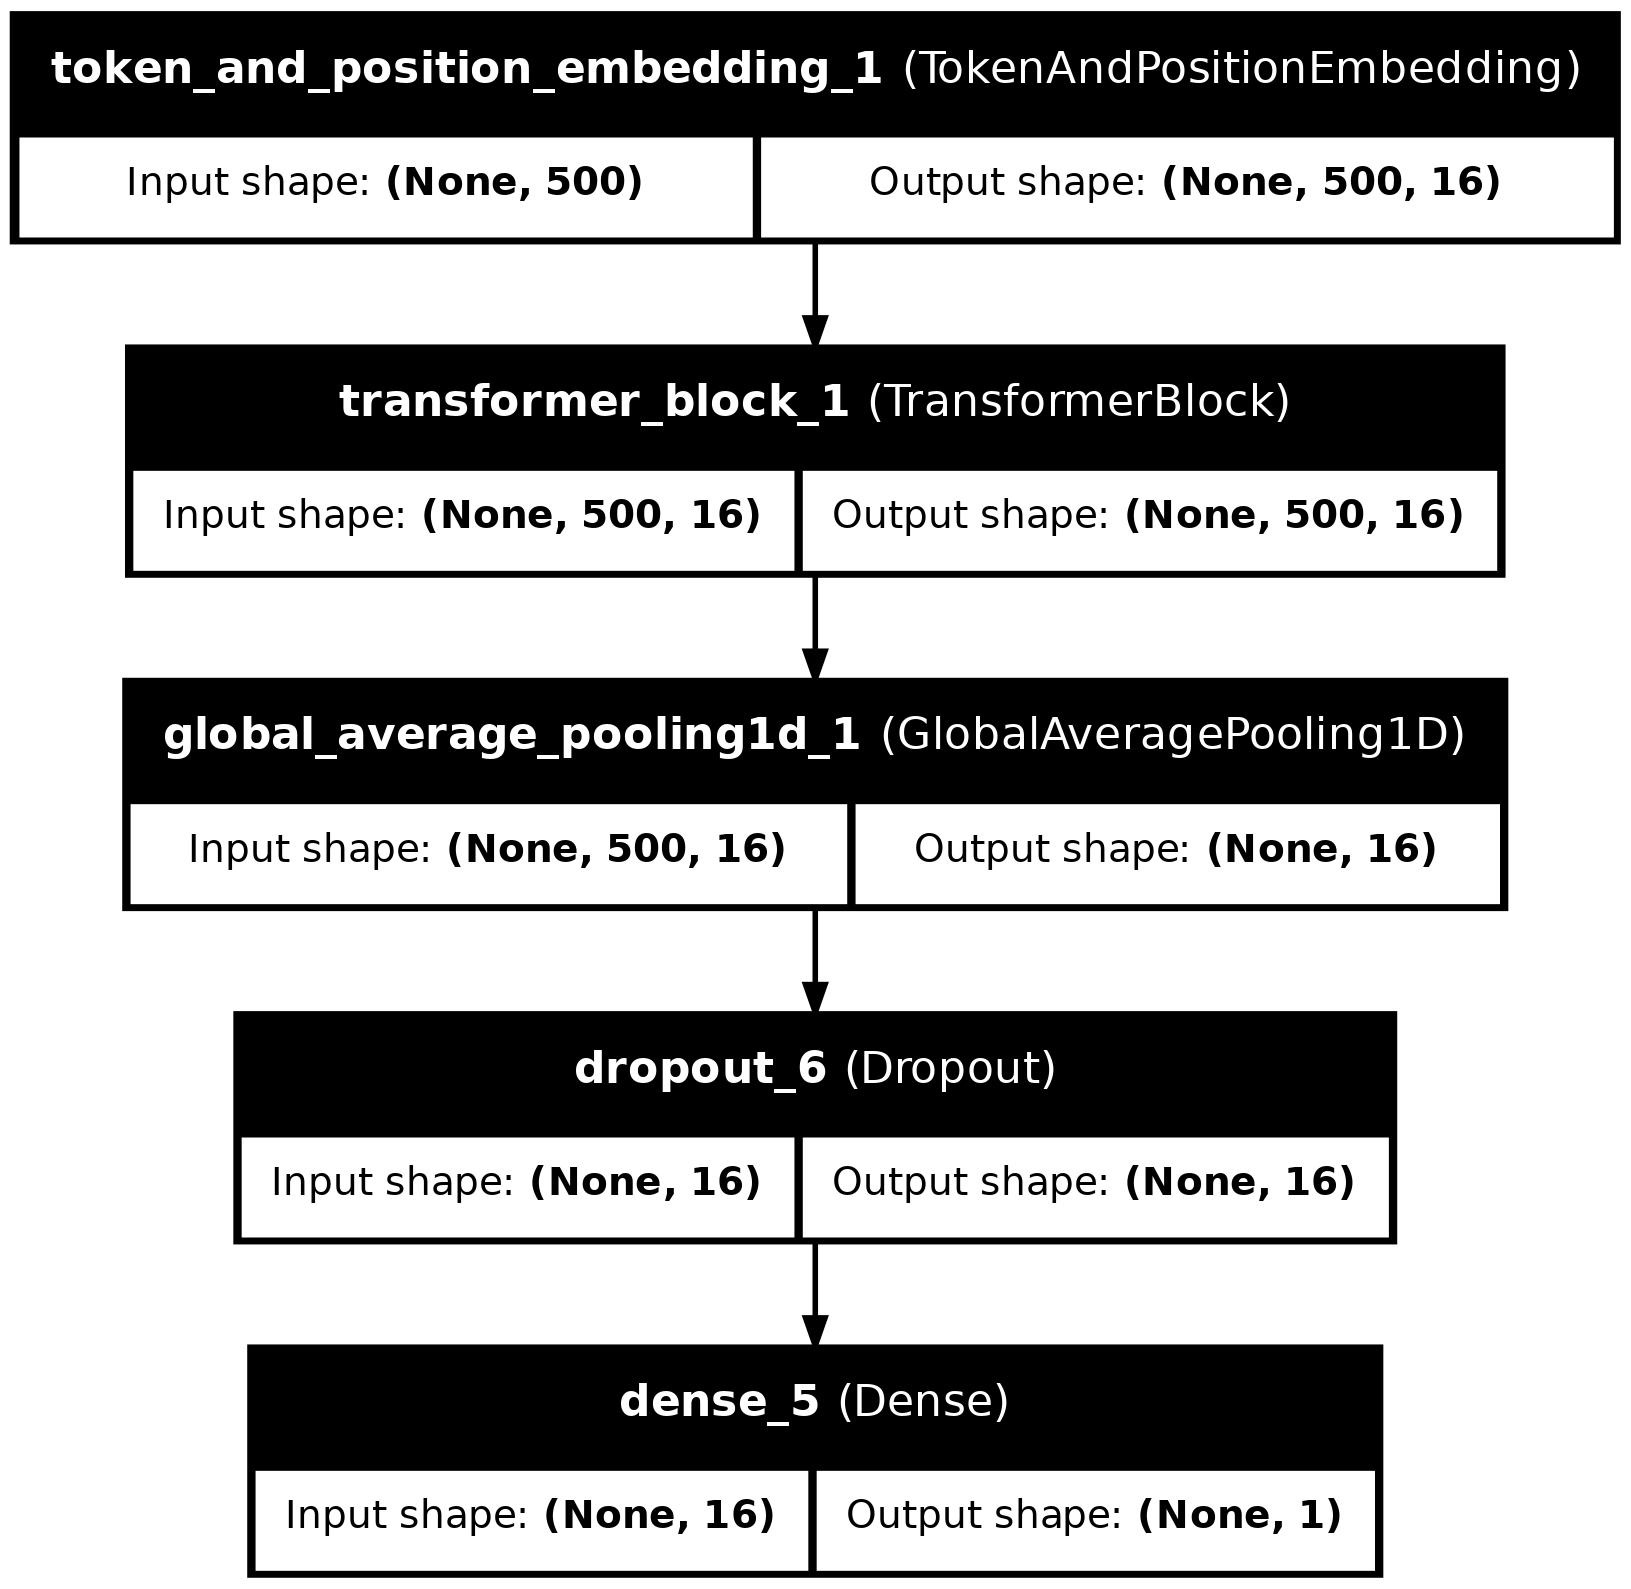

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [17]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0004),
              metrics=[tf.metrics.BinaryAccuracy()])

In [18]:
train_ds2 = train_ds.map(vectorize_text)
val_ds2 = val_ds.map(vectorize_text)
test_ds2 = test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE
train_ds2 = train_ds2.cache().prefetch(buffer_size=AUTOTUNE)
val_ds2 = val_ds2.cache().prefetch(buffer_size=AUTOTUNE)
test_ds2 = test_ds2.cache().prefetch(buffer_size=AUTOTUNE)

epochs = 12
history = model.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=epochs, batch_size=batch_size,
    validation_steps=30)

Epoch 1/12


I0000 00:00:1715451187.865513      97 service.cc:145] XLA service 0x7f5d400135a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715451187.865535      97 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-05-11 18:13:07.904079: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-11 18:13:08.086470: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  26/1219 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - binary_accuracy: 0.5244 - loss: 0.7357

I0000 00:00:1715451192.522813      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1219/1219 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - binary_accuracy: 0.5868 - loss: 0.6087 - val_binary_accuracy: 0.8922 - val_loss: 0.2442
Epoch 2/12
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - binary_accuracy: 0.9073 - loss: 0.2240 - val_binary_accuracy: 0.9115 - val_loss: 0.2051
Epoch 3/12
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - binary_accuracy: 0.9172 - loss: 0.2009 - val_binary_accuracy: 0.9141 - val_loss: 0.2058
Epoch 4/12
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - binary_accuracy: 0.9195 - loss: 0.1930 - val_binary_accuracy: 0.9073 - val_loss: 0.2170
Epoch 5/12
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - binary_accuracy: 0.9214 - loss: 0.1884 - val_binary_accuracy: 0.9052 - val_loss: 0.2203
Epoch 6/12
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - binary_accuracy: 0.9222 - loss: 0.1852 - val_binary_accuracy: 0.9068 - val_loss: 0.2052
Epoch 7/12
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - binary_accuracy: 0.9239 - loss: 0.1827 - val_binary_accuracy: 0.9036 - val_loss: 0.2183
E

2024-05-11 18:14:43.989003: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [19]:
loss, accuracy = model.evaluate(test_ds2)

print("Loss: ", loss)
print("Accuracy: ", accuracy)
print(model.metrics_names)

407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9168 - loss: 0.2095
Loss:  0.2138669192790985
Accuracy:  0.9158461689949036
['loss', 'compile_metrics']


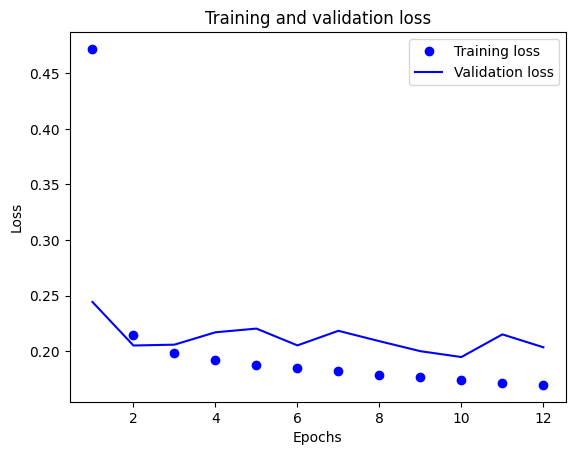

In [20]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

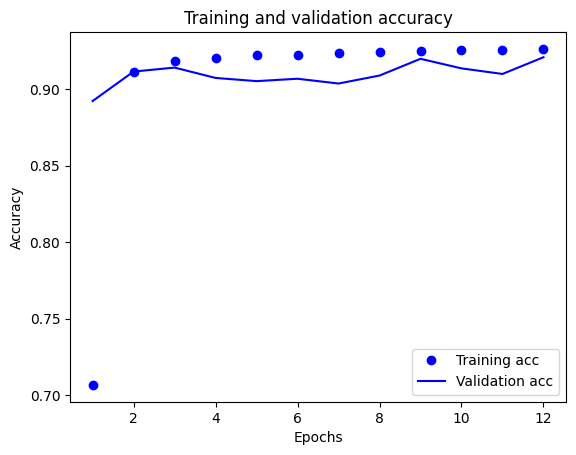

In [21]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


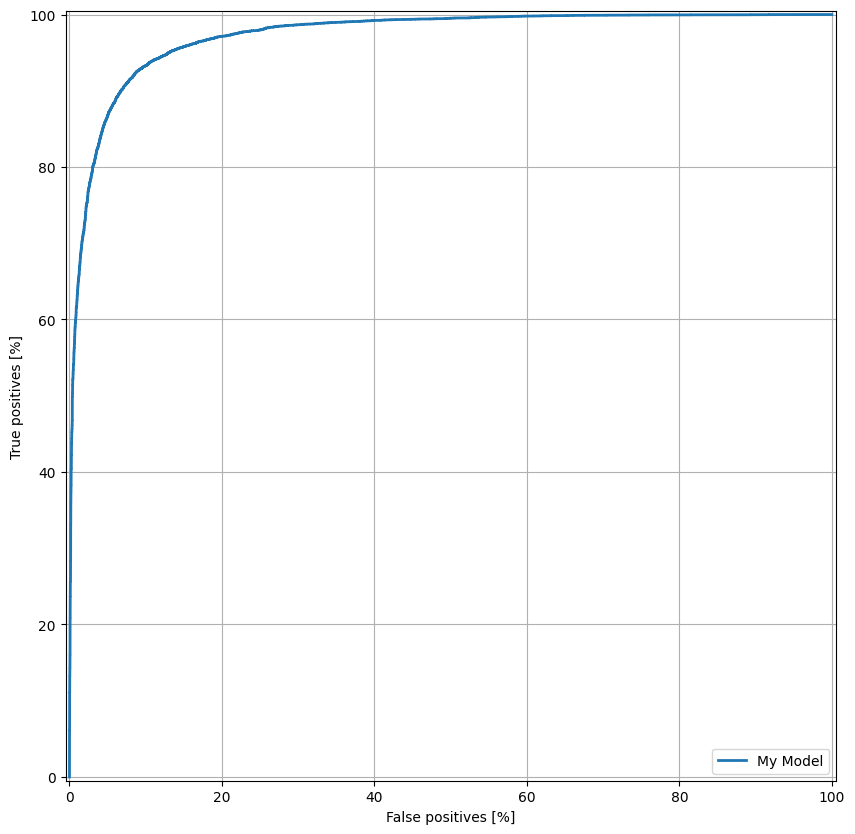

In [22]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
 
# 绘制正例ROC曲线
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions, pos_label=0)
 
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  plt.legend(loc='lower right')
  plt.show()
 
test_predictions = model.predict(test_ds2)
true_labels=test['sentiment'].values
test_scores = 1-(test_predictions - test_predictions.min())/(test_predictions.max() - test_predictions.min())
    
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("My Model", true_labels, test_scores, color=colors[0])


In [23]:
recall = recall_score(true_labels, test_predictions > 0.5)
precision = precision_score(true_labels, test_predictions > 0.5)
f1 = f1_score(true_labels, test_predictions > 0.5)
accuracy = accuracy_score(true_labels, test_predictions > 0.5)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1: ', f1)
print('Accuracy: ', accuracy)

Recall:  0.8941549404669863
Precision:  0.9338662790697675
F1:  0.9135792716644284
Accuracy:  0.9158461538461539


In [24]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

In [29]:
print(export_model.predict(np.array([b'This food is good, so I love it'], dtype=object)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[0.9484311]]


In [30]:
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

print(test_ds)
accuracy = export_model.evaluate(test_ds, return_dict=True)
print(accuracy)

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
407/407 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9182 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
{'accuracy': 0.9174615144729614, 'binary_accuracy': 0.0, 'loss': 0.0}


In [31]:
# save model
export_model.save('transformer.keras')